In [1]:
# load data
library(ncdf4)
library(ggplot2)
library(lubridate)
library(rjson)
library(rray)
library(parallel) # 载入parallel包
library(parallelly) # 载入parallel包library(parallel) # 载入parallel包
source("../helper.R")


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Warning message:
“package ‘INLA’ was built under R version 4.2.2”
Loading required package: Matrix

Loading required package: foreach

Loading required package: sp

This is INLA_22.11.22 built 2022-11-22 05:45:53 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - To enable PARDISO sparse library; see inla.pardiso()


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: carData

Loading required package: xts



In [2]:

database <- '/home/jianj0c/dataset/redsea/'

chl_data_folder  <- 'Chlorophyll/8-Days_composite/'
chl_dir_path <- paste(database,chl_data_folder,"Aqua_MODIS_chloA_8_Days_Composite.2003_2022.nc",sep="")
chl_nc_obj <- nc_open(chl_dir_path)
chl_T_array <- ncvar_get(chl_nc_obj,"chlorophyllA")

sst_data_folder  <- 'SST/Aqua_MODIS_8_days_L3m_4km_SST/'
sst_dir_path <- paste(database,sst_data_folder,"Aqua_MODIS_sstd_8day_Composite.2003_2022.nc",sep="")
sst_nc_obj <- nc_open(sst_dir_path)
sst_T_array <- ncvar_get(sst_nc_obj,"sstMasked")

longitude<-chl_nc_obj$dim[[1]]$vals
latitude <- chl_nc_obj$dim[[2]]$vals
timestamp_ch <- chl_nc_obj$dim[[3]]$vals
timestamp_sst <- sst_nc_obj$dim[[3]]$vals
## configuration
config<-fromJSON(file="../config.json")
task_paral_maximum<-parallel::detectCores()-5

### average save and load test

In [22]:
t_base<-strsplit(ncatt_get(chl_nc_obj,"time","units")$value," ")
date<-ymd(t_base[[1]][3])+dseconds(timestamp_ch)
mean_over_2006<-rowMeans(chl_T_array[,,date>"2016-01-01"&date<"2016-12-31"],na.rm=TRUE,dims=2)
sst_t_base<-strsplit(ncatt_get(sst_nc_obj,"time","units")$value," ")
sst_date<-ymd(sst_t_base[[1]][3])+dseconds(timestamp_sst)

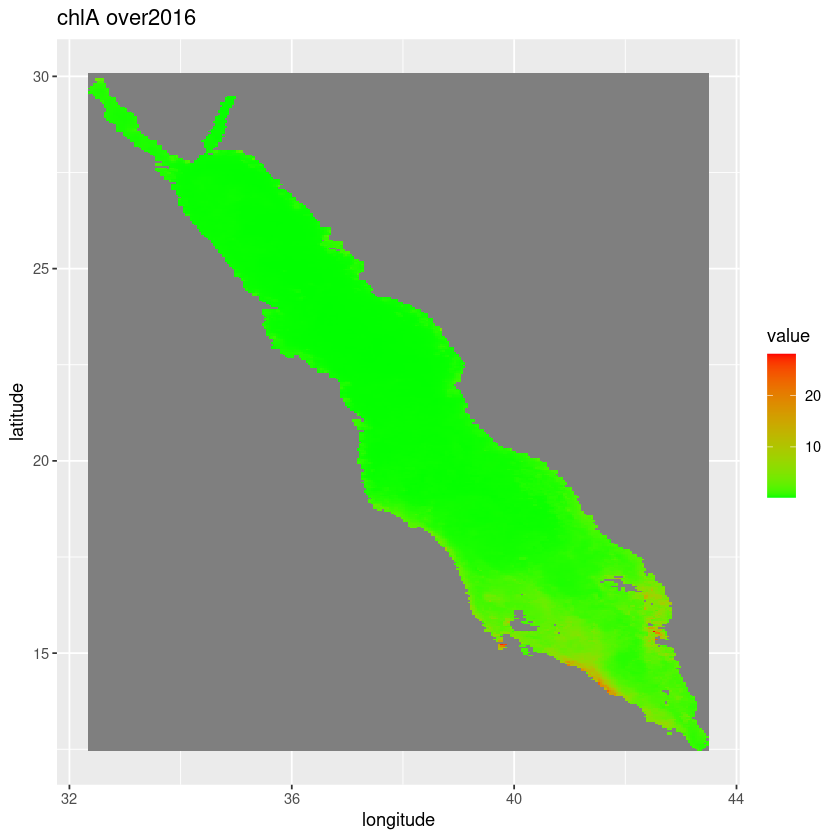

In [4]:
save(mean_over_2006,longitude,latitude,file=file.path("../tmp/mean_chlA_2016_plus_longtitude_latitude.Rdata"))
load("../tmp/mean_chlA_2016_plus_longtitude_latitude.Rdata")
visualize_frame_ggplot(mean_over_2006,latitude,longitude,title="chlA over2016")

#### filter outlier

In [5]:
sst_T_array_filter_outlier<-sst_T_array
sst_T_array_filter_outlier[pipeline_filter_for_outlier(sst_T_array,5)]=NA


chl_T_array_filter_outlier<-chl_T_array
chl_T_array_filter_outlier[pipeline_filter_for_outlier(chl_T_array,5)]=NA


In [6]:

cl <- makeClusterPSOCK(
    workers=rep(c("10.68.171.157","10.68.170.226","10.68.170.220"),3), user = "jianj0c",
  ## Manual configuration of reverse SSH tunnelling
  revtunnel = TRUE
)
clusterEvalQ(cl,source("/home/jianj0c/project/redsea/helper.R"))

[[1]]
[[1]]$value
function (T_array, date, agg_on = "Season", thres_min_data_point = 25) 
{
    results <- list()
    length_latitude <- dim(T_array)[2]
    length_longitude <- dim(T_array)[1]
    length_timestamp <- dim(T_array)[3]
    raw_t = seq(1, length_timestamp)
    if (agg_on == "Season") {
        seasonal_feature <- unlist(feature_extract_time(date)[2])
        result_matrix <- unlist(rep(list(NA), length_latitude * 
            length_longitude * 4))
        dim(result_matrix) <- c(length_latitude, length_longitude, 
            4)
    }
    else {
        seasonal_feature <- unlist(feature_extract_time(date)[1])
        result_matrix <- unlist(rep(list(NA), length_latitude * 
            length_longitude * 12))
        dim(result_matrix) <- c(length_latitude, length_longitude, 
            12)
    }
    for (latitude_i in 1:length_latitude) {
        for (longitude_i in 1:length_longitude) {
            raw_y = T_array[longitude_i, latitude_i, 1:length_timestamp]
            t <- raw_t[!is.na(raw_y)]
            y <- raw_y[!is.na(raw_y)]
            seasonal <- seasonal_feature[!is.na(raw_y)]
            if (length(t) > thres_min_data_point & length(unique(seasonal)) > 
                2) {
                data = data.frame(t, y, seasonal)
                model <- inla(y ~ t + f(seasonal, model = "rw2"), 
                  data = data, verbose = TRUE)
                results <- append(results, model$summary.random$season$mean)
                result_df <- model$summary.random$seasonal
                result_matrix[latitude_i, longitude_i, result_df$ID] = result_df$mean
            }
        }
    }
    return(result_matrix)
}

[[1]]$visible
[1] FALSE


[[2]]
[[2]]$value
function (T_array, date, agg_on = "Season", thres_min_data_point) 
{
    results <- list()
    length_latitude <- dim(T_array)[2]
    length_longitude <- dim(T_array)[1]
    length_timestamp <- dim(T_array)[3]
    raw_t = seq(1, length_timestamp)
    if (agg_on == "Season") {
        seasonal_feature <- unlist(feature_extract_time(date)[2])
        result_matrix <- unlist(rep(list(NA), length_latitude * 
            length_longitude * 4))
        dim(result_matrix) <- c(length_latitude, length_longitude, 
            4)
    }
    else {
        seasonal_feature <- unlist(feature_extract_time(date)[1])
        result_matrix <- unlist(rep(list(NA), length_latitude * 
            length_longitude * 12))
        dim(result_matrix) <- c(length_latitude, length_longitude, 
            12)
    }
    for (latitude_i in 1:length_latitude) {
        for (longitude_i in 1:length_longitude) {
            raw_y = T_array[longitude_i, latitude_i, 1:length_timestamp]
            t <- raw_t[!is.na(raw_y)]
            y <- raw_y[!is.na(raw_y)]
            seasonal <- seasonal_feature[!is.na(raw_y)]
            if (length(t) > thres_min_data_point & length(unique(seasonal)) > 
                2) {
                data = data.frame(t, y, seasonal)
                model <- inla(y ~ t + f(seasonal, model = "rw2"), 
                  data = data, verbose = TRUE)
                results <- append(results, model$summary.random$season$mean)
                result_df <- model$summary.random$seasonal
                result_matrix[latitude_i, longitude_i, result_df$ID] = result_df$mean
            }
        }
    }
    return(result_matrix)
}

[[2]]$visible
[1] FALSE


[[3]]
[[3]]$value
function (T_array, date, agg_on = "Season", thres_min_data_point) 
{
    results <- list()
    length_latitude <- dim(T_array)[2]
    length_longitude <- dim(T_array)[1]
    length_timestamp <- dim(T_array)[3]
    raw_t = seq(1, length_timestamp)
    if (agg_on == "Season") {
        seasonal_feature <- unlist(feature_extract_time(date)[2])
        result_matrix <- unlist(rep(list(NA), length_latitude * 
            length_longitude * 4))
        dim(result_matrix) <- c(length_latitude, length_longitude, 
            4)
    }
    else {
        seasonal_feature <- unlist(feature_extract_time(da

In [7]:
cl

Socket cluster with 9 nodes where 3 nodes are on host ‘10.68.170.220’ (R version 4.2.1 (2022-06-23), platform x86_64-pc-linux-gnu), 3 nodes are on host ‘10.68.170.226’ (R version 4.2.1 (2022-06-23), platform x86_64-pc-linux-gnu), 3 nodes are on host ‘10.68.171.157’ (R version 4.2.1 (2022-06-23), platform x86_64-pc-linux-gnu)

In [1]:
stopCluster(cl)

ERROR: Error in stopCluster(cl): could not find function "stopCluster"


In [9]:
anonym_func<-function(matrix,date,shape,agg_on="Season"){
    xx<-matrix(unlist(matrix))
    dim(xx)<-shape    
    return(reducer_trend_seasonal(xx,date,agg_on,25))
}


##[WARN]: this is too slow. on the ChlA. need do 20k regression on INLA. approximately will take 2 hours!
## linear regression for 3D and reduce to 3d seaonal matrix [la*lo*s]

#datas<-lapply(seq_len(dim(chl_T_array)[1]),function(i) chl_T_array[i,,])
#result<-parallel::parLapply(cl,datas[1:2],anonym_func,date=date,shape=c(1,423,890))

In [14]:
dim(sst_T_array_filter_outlier)

[1] 268 423 887

In [11]:
chl_datas<-lapply(seq_len(dim(chl_T_array_filter_outlier)[1]),function(i) chl_T_array_filter_outlier[i,,])

ChlA_season<-parallel::parLapply(cl,chl_datas[seq(1,200,10)],anonym_func,date=date,agg_on="Season",shape=c(1,423,890))
save(ChlA_season,file = file.path("../tmp/ChlA_season.Rdata"))

ChlA_month<-parallel::parLapply(cl,chl_datas[seq(1,200,10)],anonym_func,date=date,agg_on="month",shape=c(1,423,890))
save(ChlA_month,file = file.path("../tmp/ChlA_month.Rdata"))

In [26]:
length(sst_datas[seq(1,200,10)])

[1] 20

In [27]:
sst_datas<-lapply(seq_len(dim(sst_T_array_filter_outlier)[1]),function(i) sst_T_array_filter_outlier[i,,])



sst_month<-parallel::parLapply(cl,sst_datas[seq(1,200,10)],anonym_func,date=sst_date,agg_on="month",shape=c(1,423,887))
save(sst_month,file = file.path("../tmp/sst_month.Rdata"))

In [64]:
sst_season<-parallel::parLapply(cl,sst_datas[seq(1,200,10)],anonym_func,date=sst_date,agg_on="Season",shape=c(1,423,887))
save(sst_season,file = file.path("../tmp/sst_season.Rdata"))

[1] 20

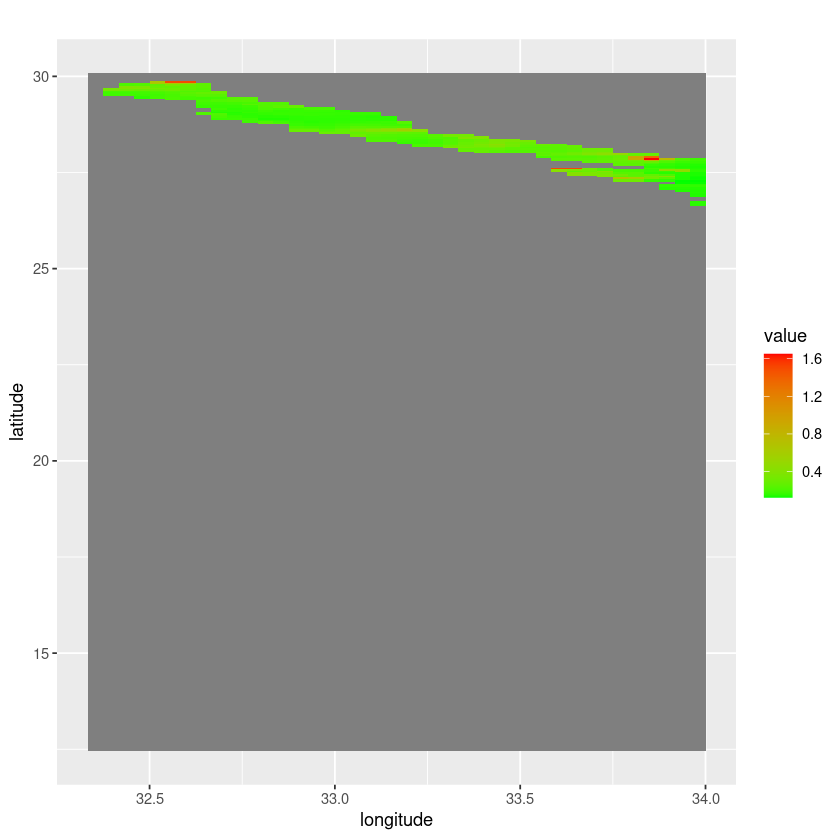

In [54]:
visualize_frame_ggplot(chl_T_array[1:40,1:423,800],latitude,longitude[1:40])

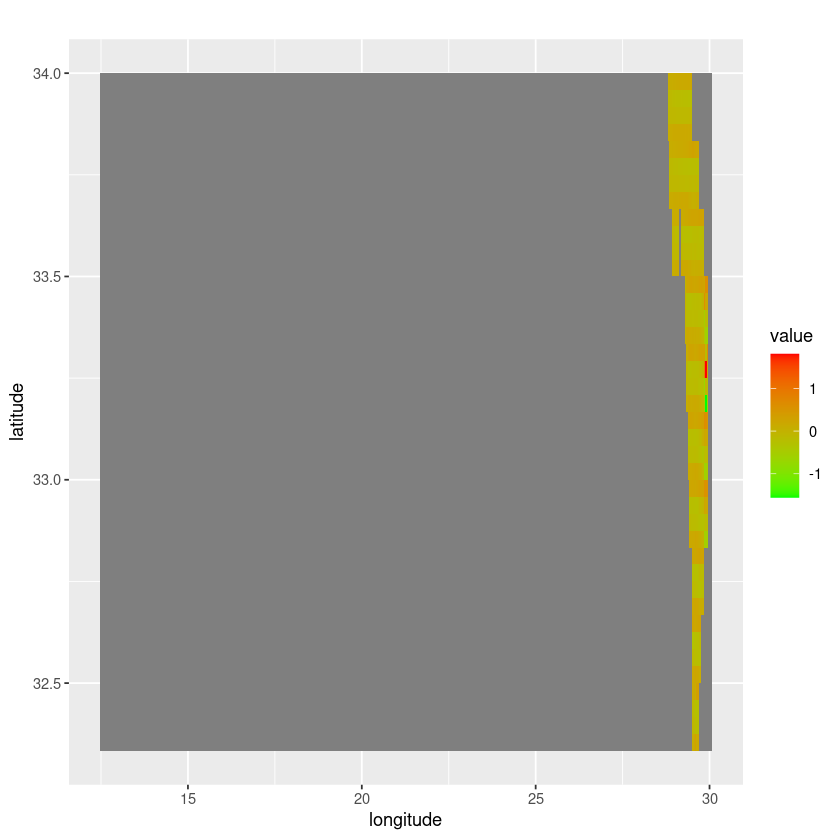

In [59]:
visualize_frame_ggplot(matrix_result[1:40,1:423,1],longitude[1:40],latitude)

In [17]:
length(unlist(xx[1]))/4

[1] 423

In [9]:
xx<-parallel::parLapply(cl,datas[1:40],anonym_func,date=date,shape=c(1,423,890))

In [11]:
datas<-lapply(seq_len(dim(chl_T_array)[1]),function(i) chl_T_array[i,,])

In [ ]:
datas<-lapply(seq_len(dim(chl_T_array)[1]),function(i) chl_T_array[i,,])

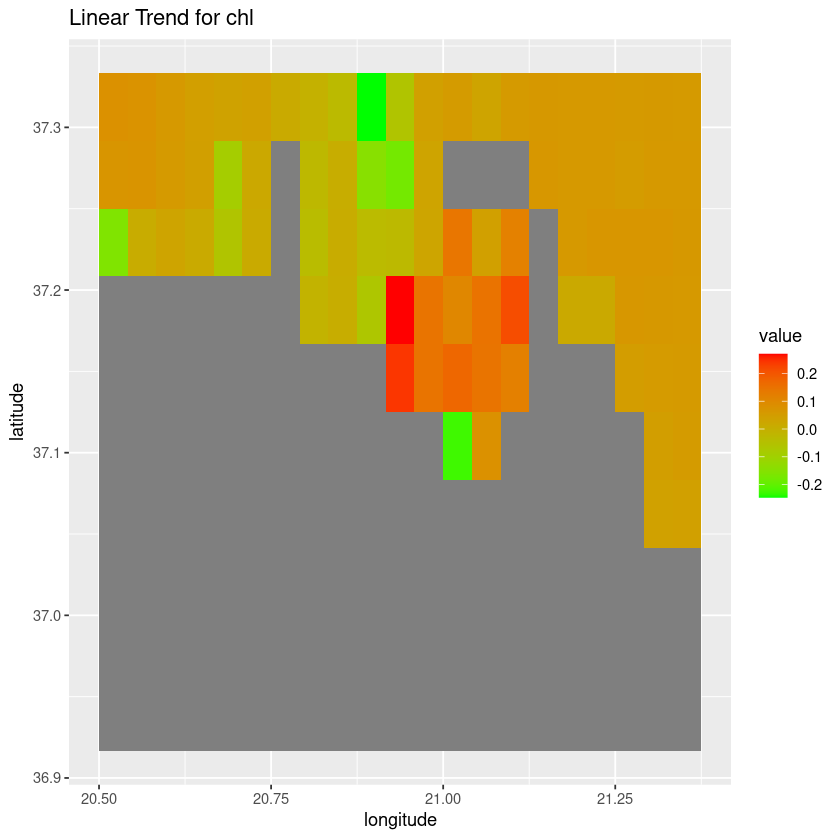

In [129]:
visualize_frame_ggplot(result[,,1],longitude[111:120],latitude[210:230],title="Linear Trend for chl")

### INLA's Tutorial

In [84]:
class(result)

[1] "function"

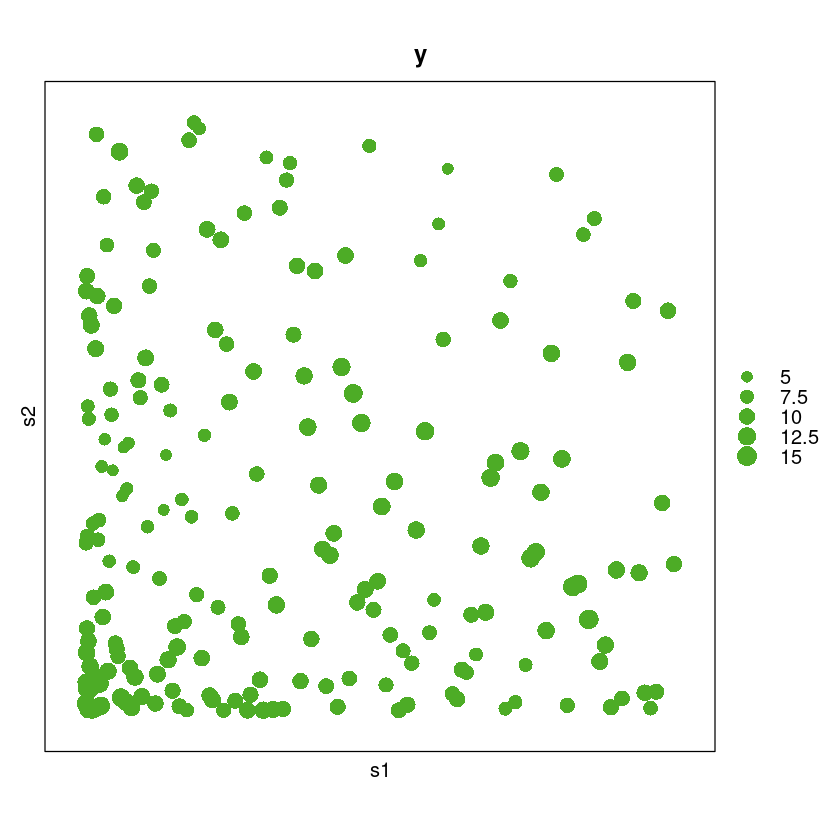

In [55]:
SPDEtoy.sp <- SPDEtoy
coordinates(SPDEtoy.sp) <- ~ s1 + s2
bubble(SPDEtoy.sp, "y", key.entries = c(5, 7.5, 10, 12.5, 15),
maxsize = 2, xlab = "s1", ylab = "s2")

In [77]:
m0 <- inla(y ~ s1 + s2, data = SPDEtoy)
f.rw1 <- y ~s1+ f(s1, model = "rw1", scale.model = TRUE) +
f(s2, model = "rw1", scale.model = TRUE)
f.rw2 <- y ~ f(s1, model = "rw2") +
f(s2, model = "rw2")
m2 <- inla(f.rw1, data = SPDEtoy)

Error in s2 + f(s1, model = "rw1", scale.model = TRUE) : 
  non-numeric argument to binary operator

 *** inla.core.safe:  inla.program has crashed: rerun to get better initial values. try=1/2 
Error in s2 + f(s1, model = "rw1", scale.model = TRUE) : 
  non-numeric argument to binary operator

 *** inla.core.safe:  inla.program has crashed: rerun to get better initial values. try=2/2 
Error in s2 + f(s1, model = "rw1", scale.model = TRUE) : 
  non-numeric argument to binary operator


ERROR: Error in inla.core.safe(formula = formula, family = family, contrasts = contrasts, : *** Fail to get good enough initial values. Maybe it is due to something else.


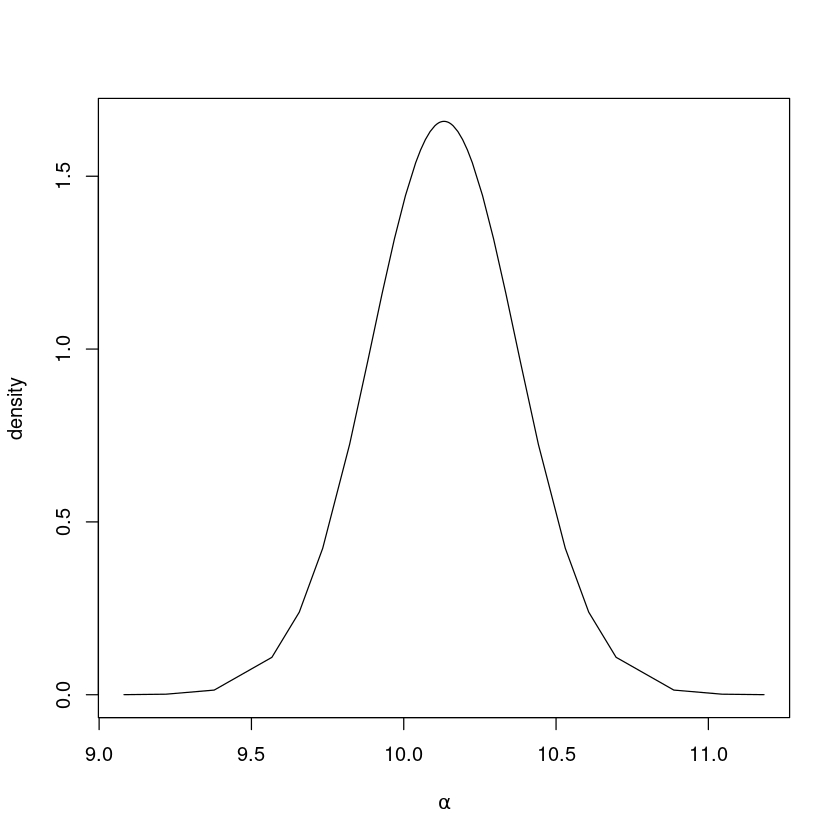

In [132]:
plot(m0$marginals.fixed[[1]], type = "l",
xlab = expression(alpha), ylab = "density")

In [73]:
?rbind

cbind                   package:base                   R Documentation

_C_o_m_b_i_n_e _R _O_b_j_e_c_t_s _b_y _R_o_w_s _o_r _C_o_l_u_m_n_s

_D_e_s_c_r_i_p_t_i_o_n:

     Take a sequence of vector, matrix or data-frame arguments and
     combine by _c_olumns or _r_ows, respectively.  These are generic
     functions with methods for other R classes.

_U_s_a_g_e:

     cbind(..., deparse.level = 1)
     rbind(..., deparse.level = 1)
     ## S3 method for class 'data.frame'
     rbind(..., deparse.level = 1, make.row.names = TRUE,
           stringsAsFactors = FALSE, factor.exclude = TRUE)
     
_A_r_g_u_m_e_n_t_s:

     ...: (generalized) vectors or matrices.  These can be given as
          named arguments.  Other R objects may be coerced as
          appropriate, or S4 methods may be used: see sections
          ‘Details’ and ‘Value’.  (For the ‘"data.frame"’ method of
          ‘cbind’ these can be further arguments to ‘data.frame

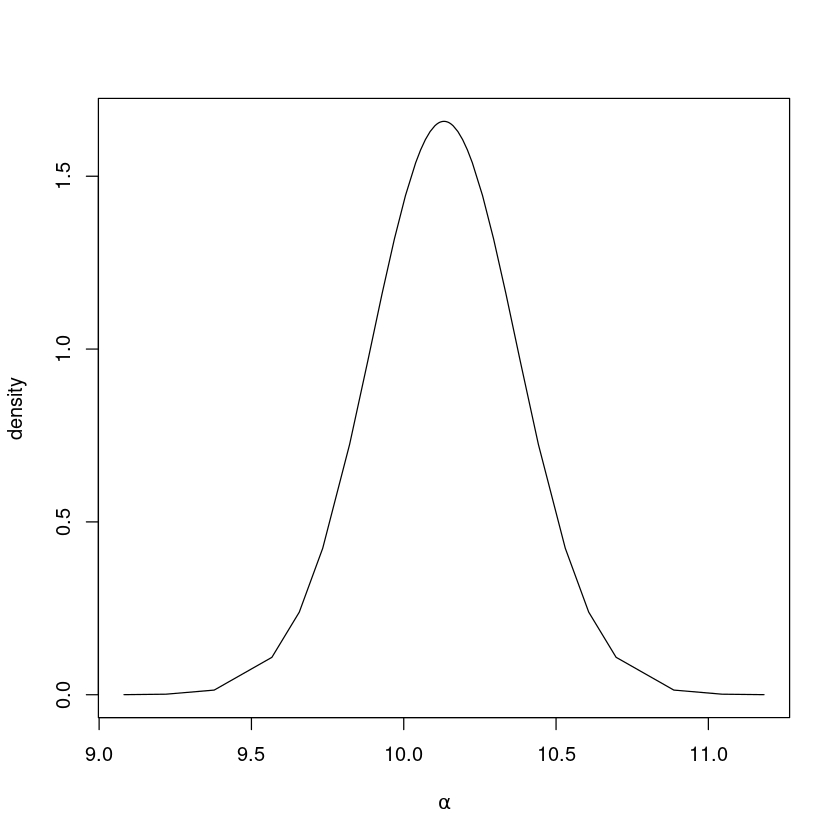

In [65]:
plot(m0$marginals.fixed[[1]], type = "l",
xlab = expression(alpha), ylab = "density")

In [153]:
formula<-y~t+f(month,model="rw2")
m1<-inla(formula,data=data)